In [1]:
import os
import pandas as pd
import requests
from sklearn.calibration import label_binarize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
# Veri dosyaları
file_paths = {
    "All_Beauty": "/content/drive/MyDrive/Colab_Notebooks/aws/meta_All_Beauty.jsonl",
    "Digital_Music": "/content/drive/MyDrive/Colab_Notebooks/aws/meta_Digital_Music.jsonl",
    "Health_and_Personal_Care": "/content/drive/MyDrive/Colab_Notebooks/aws/meta_Health_and_Personal_Care.jsonl",
}

In [4]:
# Veri seti klasörleri
base_dir = "/content/drive/MyDrive/Colab_Notebooks/aws/data"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [5]:
# 'large' etiketli görselleri filtreleyen fonksiyon
def extract_large_images(image_list):
    if isinstance(image_list, list):
        large_images = [img.get("large") for img in image_list if isinstance(img, dict) and "large" in img]
        return large_images if large_images else None
    return None

# Görselleri indirme fonksiyonu
def download_images(df, save_path, category_name, num_images=1000):
    os.makedirs(save_path, exist_ok=True)
    images_downloaded = []
    i = 0
    for image_list in tqdm(df["large_images"].dropna(), desc=f"Downloading {category_name} Images"):
        if not isinstance(image_list, list):
            continue
        for link in image_list:
            if not link:
                continue
            try:
                img_data = requests.get(link, timeout=5).content
                img_name = f"{category_name}_{i+1}.jpg"
                img_path = os.path.join(save_path, img_name)
                with open(img_path, "wb") as img_file:
                    img_file.write(img_data)
                images_downloaded.append(img_name)
                i += 1
                if i >= num_images:
                    return images_downloaded
            except requests.RequestException:
                continue
    return images_downloaded


In [6]:
# Veri işleme
for category_name, file_path in file_paths.items():
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    df = pd.read_json(file_path, lines=True)
    df["large_images"] = df["images"].apply(extract_large_images)
    category_train_path = os.path.join(train_dir, category_name)
    category_test_path = os.path.join(test_dir, category_name)
    os.makedirs(category_train_path, exist_ok=True)
    os.makedirs(category_test_path, exist_ok=True)
    downloaded_images = download_images(df, category_train_path, category_name, num_images=20)
    train_images, test_images = train_test_split(downloaded_images, test_size=0.2, random_state=42)
    for img in test_images:
        os.rename(os.path.join(category_train_path, img), os.path.join(category_test_path, img))
print("Tüm görseller başarıyla indirildi, 80-20 oranında bölündü ve kaydedildi!")

Tüm görseller başarıyla indirildi, 80-20 oranında bölündü ve kaydedildi!


In [7]:
# Model eğitimi için veri ayarları
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [8]:
# Veri dönüşümleri
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
# Veri seti yükleyiciler
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
# Model oluşturma ve ayarları
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 76.8MB/s]


In [11]:
# Model eğitimi
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")


Epoch 1/10, Loss: 0.9234, Accuracy: 45.83%
Epoch 2/10, Loss: 0.3335, Accuracy: 89.58%
Epoch 3/10, Loss: 0.6200, Accuracy: 89.58%
Epoch 4/10, Loss: 0.7110, Accuracy: 79.17%
Epoch 5/10, Loss: 0.5661, Accuracy: 85.42%
Epoch 6/10, Loss: 0.7139, Accuracy: 81.25%
Epoch 7/10, Loss: 0.5121, Accuracy: 79.17%
Epoch 8/10, Loss: 0.7317, Accuracy: 81.25%
Epoch 9/10, Loss: 0.4031, Accuracy: 81.25%
Epoch 10/10, Loss: 0.2889, Accuracy: 91.67%


In [12]:
# Model değerlendirme
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
print(f'Test Doğruluk Oranı: {100 * sum(np.array(y_true) == np.array(y_pred)) / len(y_true):.2f}%')


Test Doğruluk Oranı: 41.67%


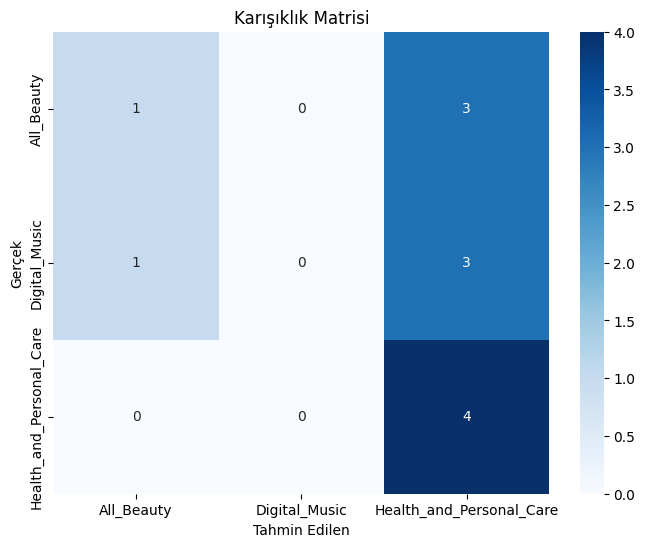

                          precision    recall  f1-score   support

              All_Beauty       0.50      0.25      0.33         4
           Digital_Music       0.00      0.00      0.00         4
Health_and_Personal_Care       0.40      1.00      0.57         4

                accuracy                           0.42        12
               macro avg       0.30      0.42      0.30        12
            weighted avg       0.30      0.42      0.30        12



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
# Karışıklık matrisi ve ROC eğrisi
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Karışıklık Matrisi')
plt.show()
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))


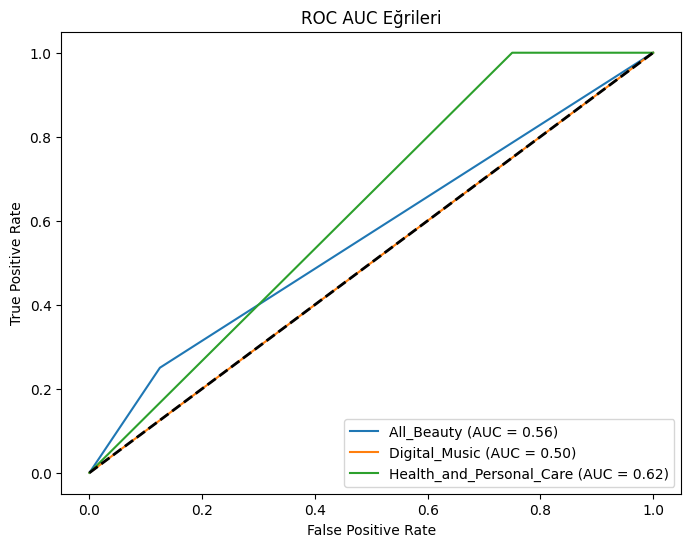

In [14]:
# ROC AUC Grafiği
y_true_bin = label_binarize(y_true, classes=np.arange(len(train_dataset.classes)))
y_pred_bin = label_binarize(y_pred, classes=np.arange(len(train_dataset.classes)))
plt.figure(figsize=(8, 6))
for i in range(len(train_dataset.classes)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    plt.plot(fpr, tpr, label=f'{train_dataset.classes[i]} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Eğrileri')
plt.legend(loc="lower right")
plt.show()